# Model visualisation

- **Author**: Jack Oliver
- **Date**: 30/04/2024
- **Purpose**: Create a draft visualisation to visually examine model dynamics.

## Imports & data

In [1]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import os, datetime

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from model import *
from model_presets import BASELINE_MODEL, HIGH_MOVEMENT

## Visualisation experiment

In [2]:
m = BaselineModel(**BASELINE_MODEL)
data, _ = m.run(with_progress=True)

100%|████████████████████████████████████████| 800/800 [00:05<00:00, 159.74it/s]


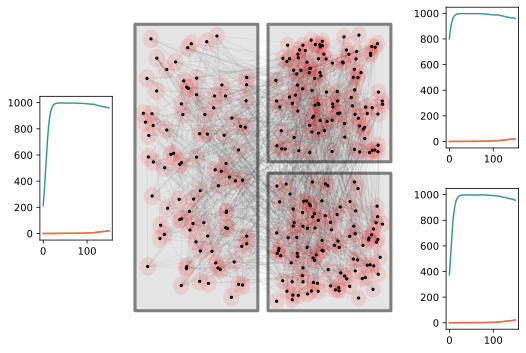

In [34]:
# Configure layout

scale_factor = 1.2

fig = plt.figure(constrained_layout=True, figsize=(6*scale_factor, 4*scale_factor))
gs  = fig.add_gridspec(nrows=4, ncols=6)

sei1 = fig.add_subplot(gs[1:3, 0])
sei2 = fig.add_subplot(gs[:2, 5])
sei3 = fig.add_subplot(gs[2:, 5])
sei_plots = [sei1, sei2, sei3]

patch_area = fig.add_subplot(gs[:, 1:5])
patch_area.xaxis.set_ticklabels([])
patch_area.yaxis.set_ticklabels([])
patch_area.set_xticks([])
patch_area.set_yticks([])

for spine in ['top','bottom','left','right']:
    patch_area.spines[spine].set_linewidth(0)

# Create boxes representing patches
mid_sep = .48
padding = .03
patch_rects = [((0, 0), mid_sep, 1), ((1-mid_sep, 1-mid_sep), mid_sep, mid_sep), ((1-mid_sep, 0), mid_sep, mid_sep)]

for p_args in patch_rects:
    patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='grey', alpha=.2))
    patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='none'))

# Set node locations and plot
patch_node = {k : {node.node_id : [np.random.uniform(low=patch_rects[k][0][0]+padding, high=patch_rects[k][0][0]+patch_rects[k][1]-padding),
                                   np.random.uniform(low=patch_rects[k][0][1]+padding, high=patch_rects[k][0][1]+patch_rects[k][2]-padding)] for node in m.patches[k].nodes} for k in range(len(m.patches))}
node_pos   = {**patch_node[0], **patch_node[1], **patch_node[2]}
nx.draw_networkx_nodes(m.graph, pos=node_pos, ax=patch_area, node_color='black', node_size=5)
nx.draw_networkx_edges(m.graph, pos=node_pos, ax=patch_area, alpha=.05)

t = 600 # time in ticks

# Display vector SEI progression so far
for patch_id in range(3):
    for (i, c) in zip(range(3), ["#41949A", "#e79f31", "#E56E5A"]):
        sei_plots[patch_id].plot(np.linspace(0, t/4, t), data["patch_sei"][patch_id][:t, i], color=c)


# Display current heatmap of disease in ABM
max_rad = .1
for node_id in range(300):
    if (i_val:=data["node_seir"][node_id][t][2]) > 0:
        patch_area.add_patch(mpatches.Circle(node_pos[node_id], radius=1*i_val/np.sum(data["node_seir"][node_id][t]), linewidth=None, facecolor='red', alpha=.1))

plt.show()

## Visualisation animation

In [2]:
def make_visualisation_from_model(model, num_frames=10, scale_factor=1.2, save_to="saved_runs"):
    """Makes a visualisation"""
    # Run model
    print("Running model...")
    data, _ = model.run(with_progress=True)
    
    # Calculate sampling rate for animation
    tick_samples = list(map(int,np.linspace(0, model.total_time/model.timestep-1, num_frames)))
    
    # Initialise node locations and plot
    mid_sep = .48
    padding = .03
    patch_rects = [((0, 0), mid_sep, 1), ((1-mid_sep, 1-mid_sep), mid_sep, mid_sep), ((1-mid_sep, 0), mid_sep, mid_sep)]
    patch_node = {k : {node.node_id : [np.random.uniform(low=patch_rects[k][0][0]+padding, high=patch_rects[k][0][0]+patch_rects[k][1]-padding),
                                       np.random.uniform(low=patch_rects[k][0][1]+padding, high=patch_rects[k][0][1]+patch_rects[k][2]-padding)] for node in model.patches[k].nodes} for k in range(len(model.patches))}
    node_pos   = {**patch_node[0], **patch_node[1], **patch_node[2]}

    # Create loc to save
    dirname = f"{save_to}/{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_run"
    os.makedirs(dirname)
    
    # Run visualisation loop
    print("Animating model...")
    for t in tqdm_notebook(tick_samples):
        # Configure layout
        fig = plt.figure(constrained_layout=True, figsize=(6*scale_factor, 4*scale_factor))
        gs  = fig.add_gridspec(nrows=4, ncols=6)
        
        sei1 = fig.add_subplot(gs[1:3, 0])
        sei2 = fig.add_subplot(gs[:2, 5])
        sei3 = fig.add_subplot(gs[2:, 5])
        sei_plots = [sei1, sei2, sei3]

        for i, ax in enumerate(sei_plots):
            ax.set_ylim(0, model.K_v_arr[i])
        
        patch_area = fig.add_subplot(gs[:, 1:5])
        patch_area.xaxis.set_ticklabels([])
        patch_area.yaxis.set_ticklabels([])
        patch_area.set_xticks([])
        patch_area.set_yticks([])
        
        for spine in ['top','bottom','left','right']:
            patch_area.spines[spine].set_linewidth(0)
            
        for p_args in patch_rects:
            patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='grey', alpha=.2))
            patch_area.add_patch(mpatches.Rectangle(*p_args, linewidth=3, edgecolor='grey', facecolor='none'))
        
        nx.draw_networkx_nodes(model.graph, pos=node_pos, ax=patch_area, node_color='black', node_size=5)
        nx.draw_networkx_edges(model.graph, pos=node_pos, ax=patch_area, alpha=.05)
        
        # Display vector SEI progression so far
        for patch_id in range(3):
            for (i, c) in zip(range(3), ["#41949A", "#e79f31", "#E56E5A"]):
                sei_plots[patch_id].plot(np.linspace(0, t/4, t), data["patch_sei"][patch_id][:t, i], color=c)
        
        
        # Display current heatmap of disease in ABM
        max_rad = .1
        for node_id in range(300):
            if (i_val:=data["node_seir"][node_id][t][2]) > 0:
                patch_area.add_patch(mpatches.Circle(node_pos[node_id], radius=1*i_val/np.sum(data["node_seir"][node_id][t]), linewidth=None, facecolor='red', alpha=.1))

        plt.savefig(f"{dirname}/{t}.png")
        plt.close()

In [3]:
make_visualisation_from_model(BaselineModel(**BASELINE_MODEL), num_frames=10)

Running model...


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 150.89it/s]

Animating model...


  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
make_visualisation_from_model(BaselineModel(**HIGH_MOVEMENT), num_frames=50)

Running model...


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 160.30it/s]

Animating model...


  0%|          | 0/50 [00:00<?, ?it/s]